In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf

import medmnist
from medmnist import INFO

In [3]:
data_flag = "dermamnist"
info = INFO[data_flag]
DataClass = getattr(medmnist, info["python_class"])

test_dataset = DataClass(split="test", download=True)
x_test, y_test = test_dataset.imgs, test_dataset.labels

# preprocess like Notebook 1
x_test = x_test.astype("float32") / 255.0
if x_test.ndim == 3:
    x_test = x_test[..., None]

y_test = y_test.squeeze()
num_classes = len(info["label"])

print("x_test:", x_test.shape, "y_test:", y_test.shape, "num_classes:", num_classes)

x_test: (2005, 28, 28, 3) y_test: (2005,) num_classes: 7


In [4]:
model = keras.models.load_model("../data/baseline_model.keras")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,265,495 (4.83 MB)

 Trainable params: 421,831 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 843,664 (3.22 MB)

In [5]:
def mc_predict(model, x, T=30, batch_size=256):
    """
    Returns:
      probs_T: shape (T, N, C) - stochastic softmax probs
      probs_mean: shape (N, C) - mean probs
    """
    probs_list = []
    N = x.shape[0]

    for t in range(T):
        preds = []
        for i in range(0, N, batch_size):
            x_batch = x[i:i+batch_size]
            p = model(x_batch, training=True).numpy()  # dropout ON
            preds.append(p)
        probs_list.append(np.concatenate(preds, axis=0))

    probs_T = np.stack(probs_list, axis=0)
    probs_mean = probs_T.mean(axis=0)
    return probs_T, probs_mean

In [6]:
T = 30
probs_T, probs_mean = mc_predict(model, x_test, T=T, batch_size=256)

y_pred = np.argmax(probs_mean, axis=1)
conf_mean = np.max(probs_mean, axis=1)

print("MC mean accuracy:", (y_pred == y_test).mean())

MC mean accuracy: 0.7376558603491272


In [7]:
eps = 1e-12
entropy = -np.sum(probs_mean * np.log(probs_mean + eps), axis=1)  # (N,)
print("Entropy range:", float(entropy.min()), "to", float(entropy.max()))

Entropy range: 0.00019415386486798525 to 1.8247895240783691


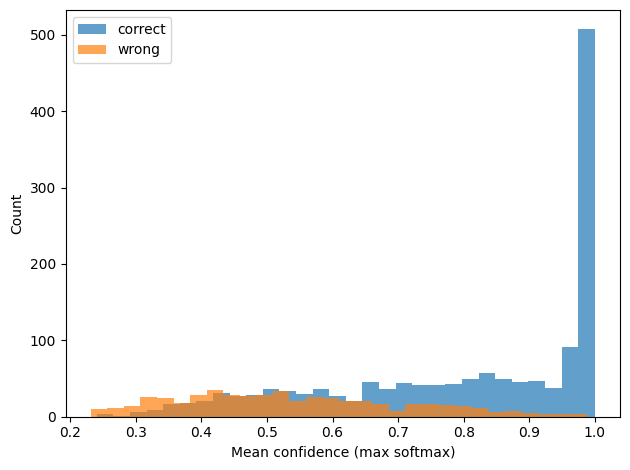

In [8]:
correct = (y_pred == y_test)

plt.figure()
plt.hist(conf_mean[correct], bins=30, alpha=0.7, label="correct")
plt.hist(conf_mean[~correct], bins=30, alpha=0.7, label="wrong")
plt.xlabel("Mean confidence (max softmax)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/confidence_correct_vs_wrong.png")
plt.show()

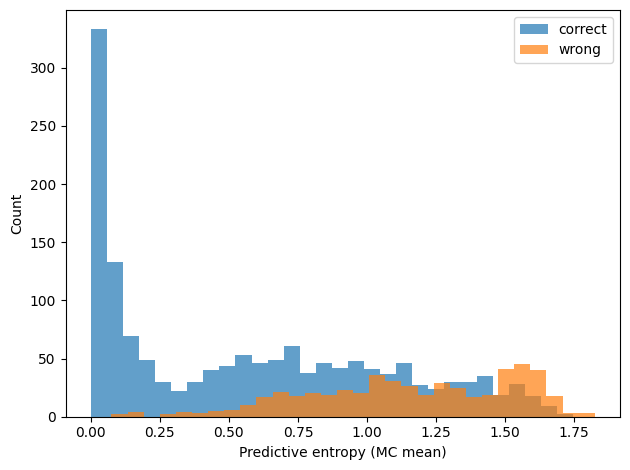

In [9]:
plt.figure()
plt.hist(entropy[correct], bins=30, alpha=0.7, label="correct")
plt.hist(entropy[~correct], bins=30, alpha=0.7, label="wrong")
plt.xlabel("Predictive entropy (MC mean)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/entropy_correct_vs_wrong.png")
plt.show()

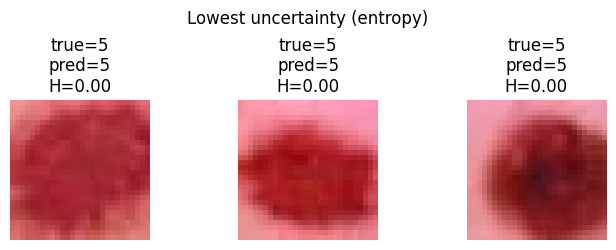

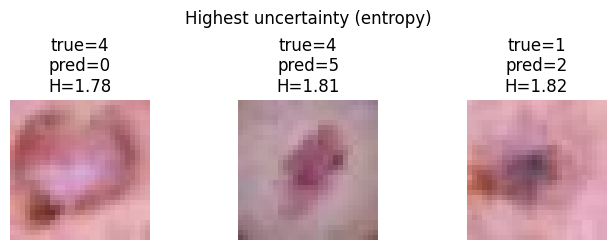

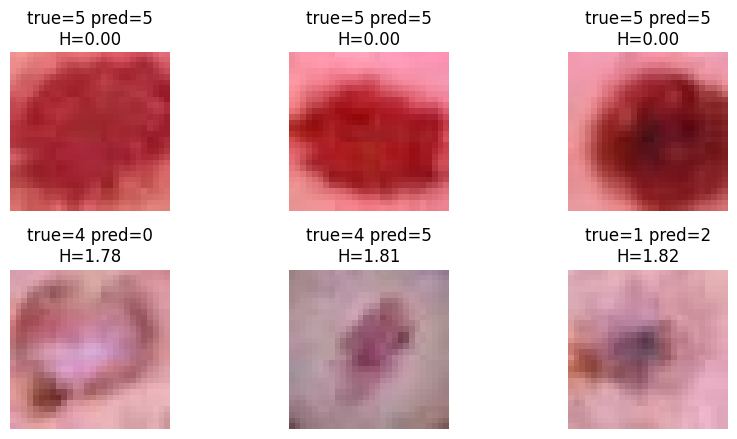

In [10]:
# pick 3 lowest-entropy and 3 highest-entropy samples
idx_sorted = np.argsort(entropy)
low_idx = idx_sorted[:3]
high_idx = idx_sorted[-3:]

def show_examples(idxs, title):
    plt.figure(figsize=(7, 2.5))
    for j, idx in enumerate(idxs):
        plt.subplot(1, len(idxs), j+1)
        plt.imshow(x_test[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(
            f"true={y_test[idx]}\npred={y_pred[idx]}\nH={entropy[idx]:.2f}"
        )
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_examples(low_idx, "Lowest uncertainty (entropy)")
show_examples(high_idx, "Highest uncertainty (entropy)")

# Save combined (one figure with 2 rows)
plt.figure(figsize=(9, 4.5))
for j, idx in enumerate(low_idx):
    plt.subplot(2, 3, j+1)
    plt.imshow(x_test[idx].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"true={y_test[idx]} pred={y_pred[idx]}\nH={entropy[idx]:.2f}")

for j, idx in enumerate(high_idx):
    plt.subplot(2, 3, 3+j+1)
    plt.imshow(x_test[idx].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"true={y_test[idx]} pred={y_pred[idx]}\nH={entropy[idx]:.2f}")

plt.tight_layout()
plt.savefig("../figures/uncertainty_examples.png")
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

print("MC Dropout (mean probs) classification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

MC Dropout (mean probs) classification report:
              precision    recall  f1-score   support

           0      0.467     0.212     0.292        66
           1      0.415     0.573     0.482       103
           2      0.546     0.432     0.482       220
           3      0.000     0.000     0.000        23
           4      0.537     0.099     0.167       223
           5      0.800     0.950     0.868      1341
           6      0.625     0.517     0.566        29

    accuracy                          0.738      2005
   macro avg      0.484     0.398     0.408      2005
weighted avg      0.700     0.738     0.695      2005

Confusion matrix:
[[  14   24   10    0    1   16    1]
 [   0   59   11    0    1   28    4]
 [   7   12   95    0    5  101    0]
 [   2   12    2    0    0    7    0]
 [   6    6   28    1   22  158    2]
 [   1   24   28    0   12 1274    2]
 [   0    5    0    0    0    9   15]]


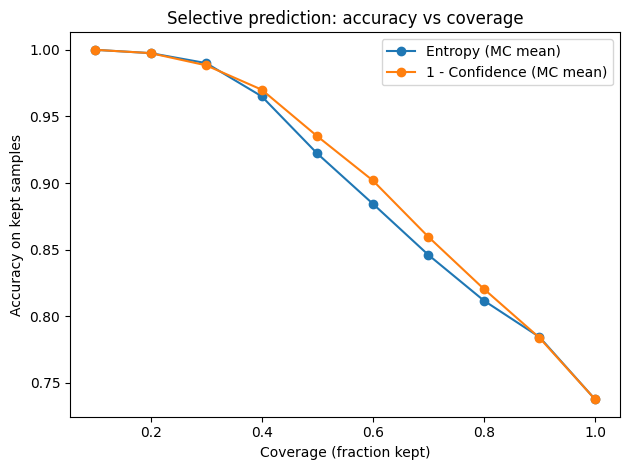

Selective accuracy @ 50% coverage (Entropy): 0.9221556886227545
Selective accuracy @ 50% coverage (1-Conf): 0.935129740518962


In [12]:
def selective_accuracy_curve(y_true, y_pred, uncertainty, coverages):
    """
    uncertainty: lower = better (more certain)
    coverages: fractions between 0 and 1
    """
    idx = np.argsort(uncertainty)  # keep most certain first
    accs = []
    for c in coverages:
        k = max(1, int(len(y_true) * c))
        sel = idx[:k]
        accs.append((y_pred[sel] == y_true[sel]).mean())
    return np.array(accs)

coverages = np.linspace(0.1, 1.0, 10)

# Two uncertainty scores:
unc_entropy = entropy                 # lower entropy = more certain
unc_1minusconf = 1.0 - conf_mean      # lower (1-conf) = more certain

acc_entropy = selective_accuracy_curve(y_test, y_pred, unc_entropy, coverages)
acc_conf    = selective_accuracy_curve(y_test, y_pred, unc_1minusconf, coverages)

plt.figure()
plt.plot(coverages, acc_entropy, marker="o", label="Entropy (MC mean)")
plt.plot(coverages, acc_conf, marker="o", label="1 - Confidence (MC mean)")
plt.xlabel("Coverage (fraction kept)")
plt.ylabel("Accuracy on kept samples")
plt.title("Selective prediction: accuracy vs coverage")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/selective_accuracy_curves.png")
plt.show()

print("Selective accuracy @ 50% coverage (Entropy):", acc_entropy[np.where(coverages==0.5)[0][0]] if 0.5 in coverages else "see curve")
print("Selective accuracy @ 50% coverage (1-Conf):", acc_conf[np.where(coverages==0.5)[0][0]] if 0.5 in coverages else "see curve")

ECE (MC mean confidence): 0.0102


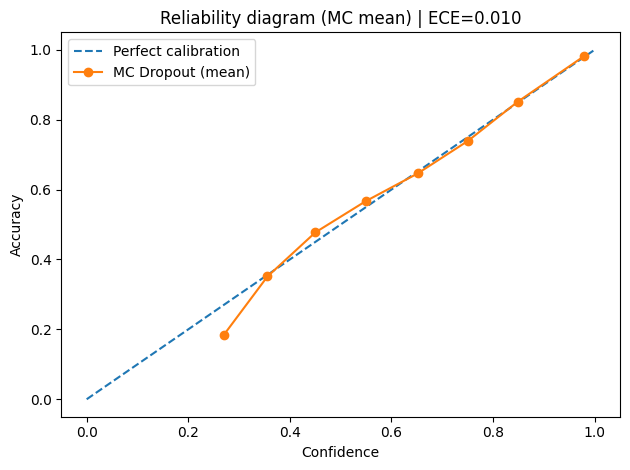

In [13]:
def reliability_diagram(y_true, y_pred, conf, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(conf, bins) - 1

    bin_acc = np.full(n_bins, np.nan, dtype=float)
    bin_conf = np.full(n_bins, np.nan, dtype=float)
    bin_count = np.zeros(n_bins, dtype=int)

    ece = 0.0
    N = len(y_true)

    for b in range(n_bins):
        mask = bin_ids == b
        cnt = mask.sum()
        bin_count[b] = cnt
        if cnt == 0:
            continue
        acc = (y_pred[mask] == y_true[mask]).mean()
        c   = conf[mask].mean()
        bin_acc[b] = acc
        bin_conf[b] = c
        ece += (cnt / N) * abs(acc - c)

    return bin_conf, bin_acc, bin_count, ece

bin_conf, bin_acc, bin_count, ece = reliability_diagram(y_test, y_pred, conf_mean, n_bins=10)
print("ECE (MC mean confidence):", round(float(ece), 4))

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.plot(bin_conf, bin_acc, marker="o", label="MC Dropout (mean)")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title(f"Reliability diagram (MC mean) | ECE={ece:.3f}")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/reliability_diagram_mc.png")
plt.show()